1830.5240089 1945.71251292
2265.66683272 m 2026.68805897 m
-0.742642857143


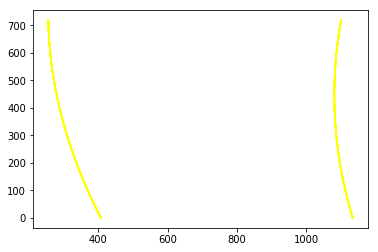

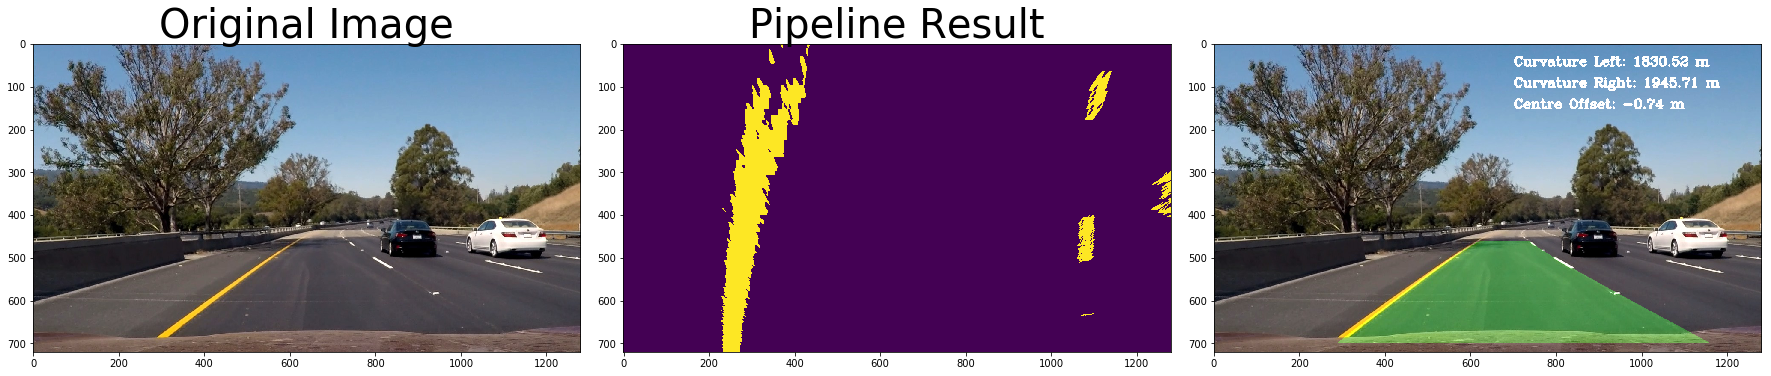

In [12]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import numpy as np
import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Read the set of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

def camera_calibration(cal_path, debug=False):
    '''
    this routine performs camera calibration
    it returns `mtx` and `dist` needed to
    undistort images taken from this camera
    '''
    # list all calibration images paths
    cal_images_names = glob.glob(cal_path)

    # chessboard-specific parameters
    nx = 9
    ny = 6

    # code below is based on classroom example
    objpoints = [] # 3D points
    imgpoints = [] # 2D points

    # (x,y,z): (0,0,0), (1,0,0), etc
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

    for fname in cal_images_names:
        # read in image
        img = cv2.imread(fname)

        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # in case chessboard was found successfully
        # it skips 3 images that do not show full chessboard (1, 4 and 5)
        if ret == True:
            # image points will be different for each calibration image
            imgpoints.append(corners)
            # object points are the same for all calibration images
            objpoints.append(objp)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            if debug:
                #plt.figure(figsize=(15,10))
                #plt.imshow(img)
                pass

    # calibration parameters calculation
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # will only use `mtx` and `dist` in this project, hence return
    return mtx, dist

def undistort_image(dist_image, mtx, dist):
        """ This function undistorts the image"""
        undist_image = cv2.undistort(dist_image, mtx, dist, None, mtx)
        
        return undist_image 
    
def plot_undistorted_image(dist_image, undist_image):
        # Plot the original distorted and undistorted image
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(dist_image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist_image)
        ax2.set_title('Undistorted Image', fontsize=50)
        
def threshold(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    #HLS Transform
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #Thd x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    #Thd color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #Stack both
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def warp(img, src, dst):
    offset = 100
    img_size = (img.shape[1], img.shape[0])
    #Bottom Left, Top Left, Top Right, Bottom Right
    #src = np.float32([[280,  700], [595,  460], [725,  460], [1125, 700]])
    #dst = dst_coordinates = np.float32([[250,  720], [250,    0], [1065,   0], [1065, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def findlanepixels_slide(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img
    
def fit_polynomial(img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = findlanepixels_slide(img)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    #To plot the polynomial on out_image
    for index in range(img.shape[0]):
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img, leftx, rightx

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit,right_fit, left_fitx, right_fitx, ploty, out_img, leftx, rightx = fit_polynomial(binary_warped)
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    #To plot the polynomial on out_image
    for index in range(binary_warped.shape[0]):
        cv2.circle(result, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(result, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    ## End visualization steps ##
    
    return result
def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    left_fit,right_fit, left_fitx, right_fitx, ploty, out_img, leftx, rightx = fit_polynomial(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_curvature_meters(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    left_fit_cr,right_fit_cr, left_fitx, right_fitx, ploty, out_img, leftx, rightx = fit_polynomial(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def centre_offset(img, leftx, rightx, xm_per_pix = 3.7/700):
    
    mid_img = img.shape[1]//2
    car_pos = (leftx[-1] + rightx[-1])/2
    offset = (mid_img - car_pos) * xm_per_pix
    return offset
    

def lane_on_original_image(img, warp_img, left_fitx, right_fitx, ploty, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    left = (left_fitx, ploty)
    right = (right_fitx, ploty)
    left_fitx = left[0]
    right_fitx = right[0]
    ploty = left[1]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    lane_on_top = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return lane_on_top

def info_print(img, left_curverad, right_curverad, offset):
    # Display lane curvature
    out = img.copy()
    cv2.putText(out, 'Curvature Left: {:.2f} m'.format(left_curverad), 
                (700, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 3)
    cv2.putText(out, 'Curvature Right: {:.2f} m'.format(right_curverad), 
                (700, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 3)
    
    # Display car offset
    cv2.putText(out, 'Centre Offset: {:.2f} m'.format(offset), 
                (700, 150), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 3)
    
    return out
    

def my_pipeline(img, mtx, dist):
    #Undistorted Image
    undistorted = undistort_image(img, mtx, dist)
    #Apply Gaussian Blur
    #blurred = cv2.GaussianBlur(undistorted, (5,5), 0)
    #Apply Color and Gradient Thresholds
    thd = threshold(undistorted, (90, 255), (20, 100))
    #Define Points for Warped Image
    #Bottom Left, Top Left, Top Right, Bottom Right
    src = np.float32([[280,  700], [595,  460], [725,  460], [1125, 700]])
    dst = dst_coordinates = np.float32([[250,  720], [250,    0], [1065,   0], [1065, 720]])
    warped, M, Minv = warp(thd,src,dst)
    #Fit polynomial for lines
    result = search_around_poly(warped)
    #Used in search_around_poly but I need to gel left and right lane coordinates
    left_fit, right_fit, left_fitx, right_fitx, ploty, out_img, leftx, rightx = fit_polynomial(warped)
    #Get Radius and Centre Offset Information
    left_curverad, right_curverad = measure_curvature_pixels(warped)
    offset = centre_offset(img, leftx, rightx, xm_per_pix = 3.7/700)
    #Lane is drawn on original image
    unwarped = lane_on_original_image(img, warped, left_fitx, right_fitx, ploty, Minv)
    unwarped = info_print(unwarped, left_curverad, right_curverad, offset)
    return unwarped
      
mtx, dist = camera_calibration('./camera_cal/calibration*.jpg',debug = True)
ca_img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted_ca = undistort_image(ca_img, mtx, dist)

img = mpimg.imread('test_images/test6.jpg')
undistorted = undistort_image(img, mtx, dist)
#blurred = cv2.GaussianBlur(undistorted, (5,5), 0)
thd = threshold(undistorted, (90, 255), (20, 100))

#Bottom Left, Top Left, Top Right, Bottom Right
src = np.float32([[280,  700], [595,  460], [725,  460], [1125, 700]])
dst = dst_coordinates = np.float32([[250,  720], [250,    0], [1065,   0], [1065, 720]])
warped, M, Minv = warp(thd,src,dst)
histo = np.copy(warped)
histogram = np.sum(histo[histo.shape[0]//2:,:], axis=0)
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img, leftx, rightx = fit_polynomial(warped)
res = search_around_poly(warped)
left_curverad, right_curverad = measure_curvature_pixels(warped)
print(left_curverad, right_curverad)
left_curverad, right_curverad = measure_curvature_meters(warped)
print(left_curverad, 'm', right_curverad, 'm')
offset = centre_offset(img, leftx, rightx, xm_per_pix = 3.7/700)
print(offset)
unwarped = lane_on_original_image(img, warped, left_fitx, right_fitx, ploty, Minv)
unwarped = my_pipeline(img, mtx, dist)




# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(unwarped)

